In [1]:
import sys
from os import listdir
from itertools import product

from inheritance_states import AutosomalInheritanceStates
from input_output import WGSData, write_to_file, pull_families
from transition_matrices import AutosomalTransitionMatrix
from genotypes import Genotypes
from losses import LazyLoss
from viterbi import viterbi_forward_sweep_autosomes, viterbi_backward_sweep_autosomes
from mask import mask_states

In [84]:
# Read in command line arguments
chrom = '15'
m = 5
ped_file = '../data/160826.ped'
data_dir = '../split_gen_miss'
batch_size = None
batch_num = None
batch_offset = None

# set up filenames
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
coord_file = '%s/chr.%s.gen.coordinates.npy' % (data_dir,  chrom)
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s' % chrom) in f and 'gen.npz' in f])


In [85]:
# pull families of interest
families_of_this_size = pull_families(sample_file, ped_file, m, batch_size, batch_offset)

families with sequence data 886
families of size 5: 352
families pulled 5: 352


In [177]:
import losses
import importlib
importlib.reload(losses)

shift_costs = [10]*4 + [500]*(2*(m-2))

# create inheritance states
inheritance_states = AutosomalInheritanceStates(m)

# create transition matrix
transition_matrix = AutosomalTransitionMatrix(inheritance_states, shift_costs)

# create genotypes
genotypes = Genotypes(m)

# create loss function
loss = losses.LazyLoss(m, inheritance_states, genotypes)
print(loss((1, 2, 1, 0, 1)))
print(loss.get_parental_variants((1, 1, 1, 1, 1, 0, 1, 1, 1, 0), (1, 2, 1, 0, 1)))
print(loss.get_parental_variants((1, 1, 1, 1, 1, 0, 1, 1, 1, 0), (2, 1, 2, 1, 2)))

# get ready to pull processed WGS data 
wgs_data = WGSData(data_dir, gen_files, coord_file, sample_file, chrom)

inheritance states (1024, 10)
transitions (1024, 22)
genotypes (1024, 5)
perfect matches (328, 5)
parental_variants 5168
losses (256, 1024)
[5 5 5 ... 2 1 1]
((1, 0, 1, -1), 1, (0.0, 0.5, 0.0, 0.5, 0.0))
((1, 1, 1, 0), 0, (0, 0, 0, 0, 0))
chrom shape only SNPs (2164322,)


In [142]:
import random

fkey, inds = random.choice(families_of_this_size)
#fkey, inds = [x for x in families_of_this_size if x[0] == ('AU0012.AU001203.AU001204', 'AU001201', 'AU001202')][0]
print('family', fkey, inds)

family ('AU0199', 'AU019901', 'AU019902') ['AU019901', 'AU019902', 'AU019905', 'AU019906', 'AU019904']


In [182]:
# pull genotype data for this family
#family_genotypes, family_snp_positions, mult_factor = wgs_data.pull_data_for_individuals(inds)
print('Data pulled')

# forward sweep
v_cost = viterbi_forward_sweep_autosomes(family_genotypes, family_snp_positions, mult_factor, inheritance_states, transition_matrix, loss)

# backward sweep
final_states = viterbi_backward_sweep_autosomes(v_cost, inheritance_states, transition_matrix)
# 14.26 sec
# 15.7 sec

Data pulled
Forward sweep complete 118.60677981376648 sec
Num solutions (1,) [[1 1 1 1 1 1 0 1 0 0]]
Num positions in fork 745
Backward sweep complete 15.577448844909668 sec


In [187]:
def estimate_parental_variants(final_states, family_genotypes):
    m, n = family_genotypes.shape
    parental_variants, cost, blame = -np.ones((4, n), dtype=np.int8), -np.ones((n,), dtype=int), -np.ones((m, n), dtype=float)
    has_missing = 0
    for i in range(n):
        state, gen = final_states[:, i], tuple(family_genotypes[:, i])
        
        missing_indices = [i for i, x in enumerate(state) if x==-1]
        
        if len(missing_indices) == 0:
            pv, v, b = loss.get_parental_variants(tuple(state), gen)
            parental_variants[:, i] = pv
            cost[i] = v
            blame[:, i] = b
        else:
            has_missing += 1
            all_possible_states = np.tile(state, (pow(2, len(missing_indices)), 1))
            all_possible_states[:, missing_indices] = list(product(*[[0, 1]]*len(missing_indices)))

            min_v = None
            all_pvs, all_bs = [], []
            for s in all_possible_states:
                pv, v, b = loss.get_parental_variants(tuple(s), gen)
                if min_v is None or v < min_v:
                    min_v = v
                    all_pvs, all_bs = [pv], [b]
                elif v == min_v:
                    all_pvs.append(pv)
                    all_bs.append(b)

            all_pvs, all_bs = np.asarray(all_pvs), np.asarray(all_bs)
            parental_variants[np.all(all_pvs==-2, axis=0), i] = -2
            parental_variants[np.all(all_pvs==0, axis=0), i] = 0
            parental_variants[np.all(all_pvs==1, axis=0), i] = 1
            cost[i] = min_v
            
            all_bs = np.sum(all_bs, axis=0)
            if min_v == 0:
                blame[:, i] = 0
            else:
                blame[:, i] = min_v*all_bs/np.sum(all_bs)
            
        if i%10000==0:
            print(i, has_missing)
    return parental_variants, cost, blame

parental_variants, cost, blame = estimate_parental_variants(final_states, family_genotypes)       

0 0
10000 0
20000 0
30000 0
40000 226
50000 226
60000 324
70000 324
80000 324
90000 324
100000 324
110000 325
120000 325
130000 361
140000 361
150000 361
160000 361
170000 361
180000 361
190000 361
200000 369
210000 369
220000 369
230000 369
240000 369
250000 369
260000 369
270000 369
280000 571
290000 571
300000 624
310000 745
320000 745
330000 745


In [198]:
import time
import numpy as np
from itertools import product

def mask_states(family_genotypes, mult_factor, final_states, inheritance_states, loss, error_rate=0.001, smooth=5000):

	masked_final_states = np.copy(final_states)
	# Now, do masking
	prev_time = time.time()
	m, n = family_genotypes.shape
	p, state_len = inheritance_states.p, inheritance_states.state_len

	fit = -np.ones((n,), dtype=int)
	prev_state = None
	prev_state_indices = None
	for j in range(n): 
		pos_gen = tuple(family_genotypes[:, j])
		current_state = tuple(final_states[:, j])

		if current_state != prev_state:
			prev_state = current_state
			num_unknowns = len([x for x in current_state if x == -1])
			if num_unknowns>0:
				prev_state_indices = []
				for poss_itr in [iter(x) for x in product(*([[0, 1]]*num_unknowns))]:
					poss_state = tuple([x if x != -1 else next(poss_itr) for x in current_state])
					prev_state_indices.append(inheritance_states.index(poss_state))
			else:
				prev_state_indices = [inheritance_states.index(tuple(final_states[:, j]))]

		fit[j] = mult_factor[j]*(np.min(loss(pos_gen)[prev_state_indices])==1)
        
	print(np.unique(fit, return_counts=True))


	c = np.convolve(fit/m, np.ones(smooth,), mode='same')
	masked = (c>(error_rate*smooth)).astype(np.int8)
	print('Percent masked', 100*np.sum(masked)/n)

	# if a parental chromosome isn't inherited, then we don't know if it has a deletion
	maternal_indices = range(4, state_len, 2)
	paternal_indices = range(5, state_len, 2)

	m1_ninh = np.all(final_states[maternal_indices, :]!=0, axis=0)
	m2_ninh = np.all(final_states[maternal_indices, :]!=1, axis=0)
	p1_ninh = np.all(final_states[paternal_indices, :]!=0, axis=0)
	p2_ninh = np.all(final_states[paternal_indices, :]!=1, axis=0)

	masked_final_states[0, m1_ninh] = -1
	masked_final_states[1, m2_ninh] = -1
	masked_final_states[2, p1_ninh] = -1
	masked_final_states[3, p2_ninh] = -1
	masked_final_states = np.append(masked_final_states, masked[np.newaxis, :], axis=0)
	print('Percent never inherited', 100*np.sum(m1_ninh)/n, 100*np.sum(m2_ninh)/n, 100*np.sum(p1_ninh)/n, 100*np.sum(p2_ninh)/n)

	print('Masking complete', time.time()-prev_time, 'sec') 
	return masked_final_states, c

In [199]:
# mask messy areas
masked_final_states, f = mask_states(family_genotypes, mult_factor, final_states, inheritance_states, loss, error_rate=0.01)
#masked_final_states[:, masked_final_states[-1, :]==1] = -1

(array([0, 1, 2, 3]), array([323599,  11609,    266,     10]))
Percent masked 18.144233406064075
Percent never inherited 12.382110622265145 16.680378199854538 7.582775929701565 10.139976869239666
Masking complete 11.894196271896362 sec


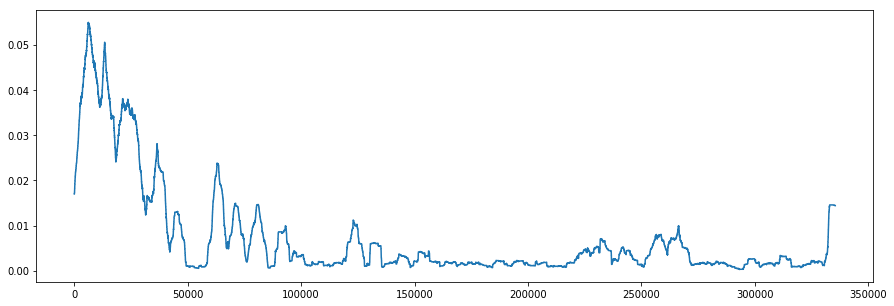

In [195]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(f/5000)
plt.show()

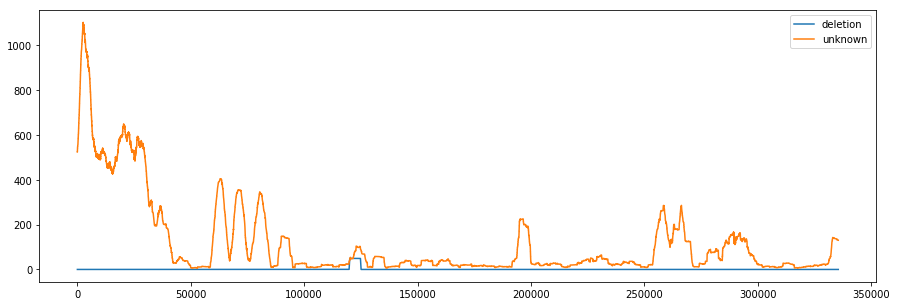

In [204]:
smooth=5000
a = np.convolve(np.sum(parental_variants==-2, axis=0)/m, np.ones(smooth,), mode='same')
b = np.convolve(np.sum(parental_variants==-1, axis=0)/m, np.ones(smooth,), mode='same')
#c = np.convolve(np.sum(parental_variants>=0, axis=0)/m, np.ones(smooth,), mode='same')

plt.figure(figsize=(15, 5))
plt.plot(a, label='deletion')
plt.plot(b, label='unknown')
plt.legend()
plt.show()

In [233]:
smooth=5000
m = np.convolve(blame[0, :], np.ones(smooth,), mode='same')/smooth
d = np.convolve(blame[1, :], np.ones(smooth,), mode='same')/smooth
c1 = np.convolve(blame[2, :], np.ones(smooth,), mode='same')/smooth
c2 = np.convolve(blame[3, :], np.ones(smooth,), mode='same')/smooth
c3 = np.convolve(blame[4, :], np.ones(smooth,), mode='same')/smooth


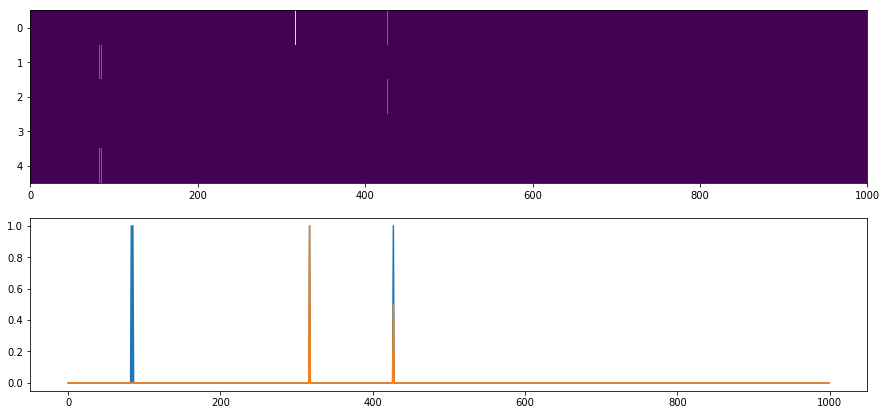

In [227]:
plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
plt.imshow(blame[:, 100000:101000], aspect='auto', vmin=0, vmax=1)
#plt.colorbar()

plt.subplot(2, 1, 2)
plt.plot(cost[100000:101000])
#plt.plot(np.sum(blame, axis=0)[100000:101000])
plt.plot(blame[0, 100000:101000])
plt.show()


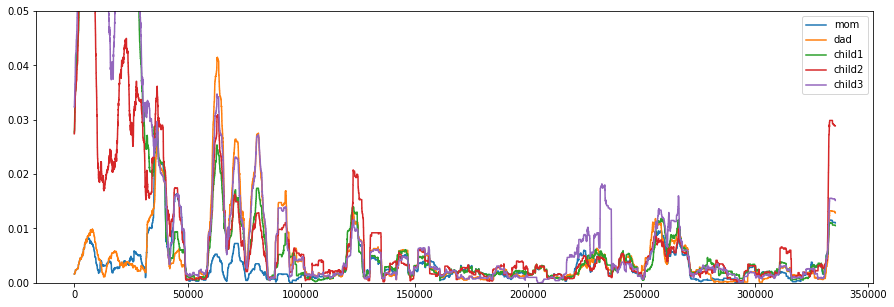

In [239]:
plt.figure(figsize=(15, 5))

plt.plot(m, label='mom')
plt.plot(d, label='dad')
plt.plot(c1, label='child1')
plt.plot(c2, label='child2')
plt.plot(c3, label='child3')
#plt.plot(b)
plt.legend()
plt.ylim([0, 0.05])
plt.show()

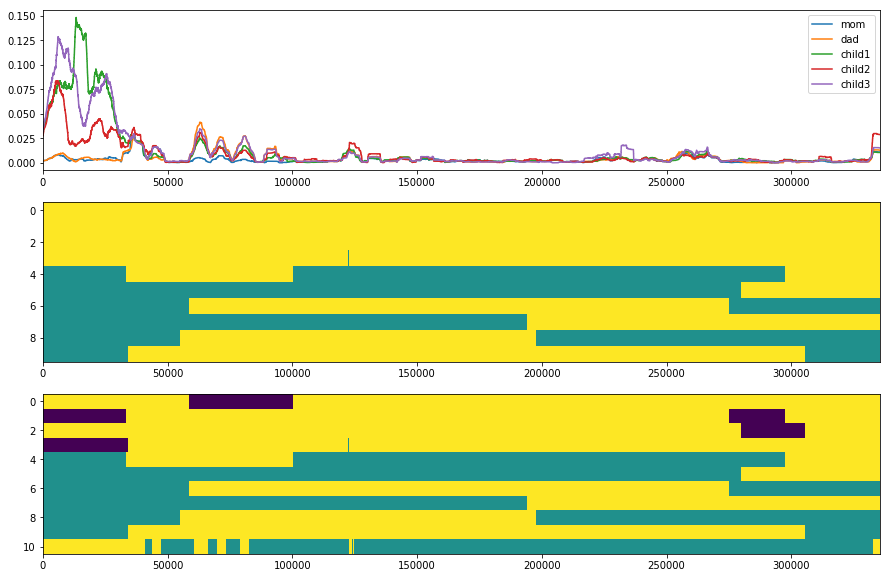

In [236]:

plt.figure(figsize=(15, 10))

ax1 = plt.subplot(3, 1, 1)
plt.plot(m, label='mom')
plt.plot(d, label='dad')
plt.plot(c1, label='child1')
plt.plot(c2, label='child2')
plt.plot(c3, label='child3')
#plt.plot(b)
plt.legend()

plt.subplot(3, 1, 2, sharex=ax1)
plt.imshow(final_states, aspect='auto')

plt.subplot(3, 1, 3, sharex=ax1)
plt.imshow(masked_final_states, aspect='auto')

plt.show()

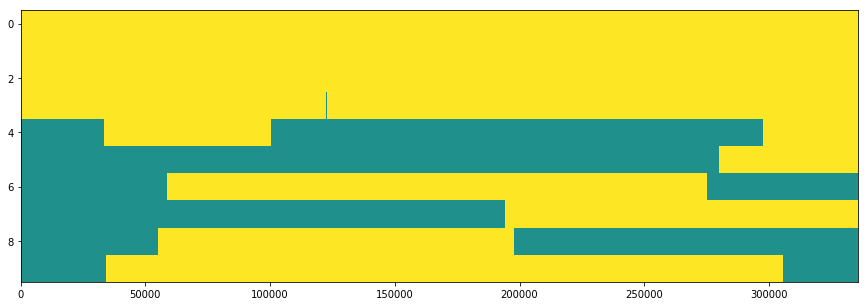

26


In [197]:
plt.figure(figsize=(15, 5))
plt.imshow(final_states, aspect='auto')
plt.show()
print(np.sum(np.any(final_states[:, 1:] != final_states[:, :-1], axis=0)))

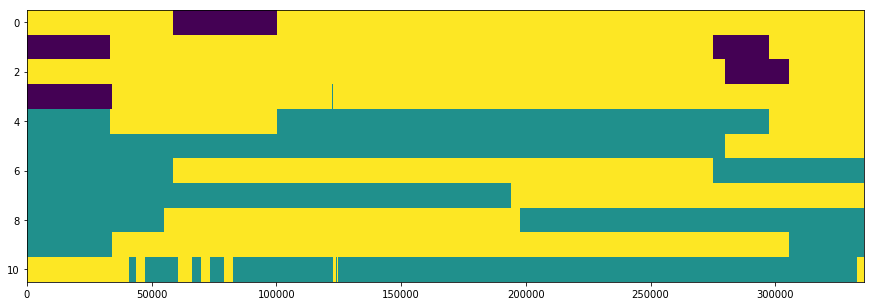

40


In [201]:
plt.figure(figsize=(15, 5))
plt.imshow(masked_final_states, aspect='auto')
plt.show()
print(np.sum(np.any(masked_final_states[4:, 1:] != masked_final_states[4:, :-1], axis=0)))

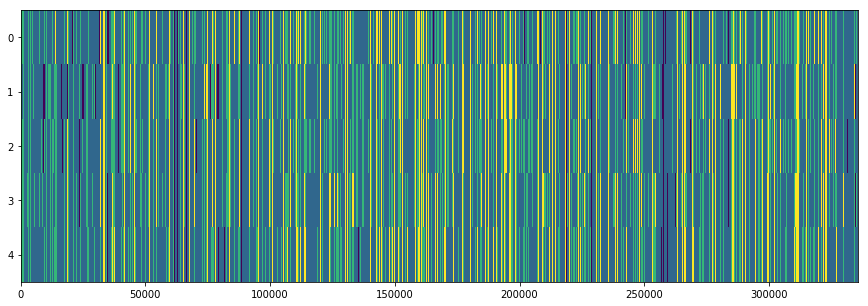

In [181]:
plt.figure(figsize=(15, 5))
plt.imshow(family_genotypes[:50000, :], aspect='auto')
plt.show()


In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(final_states, aspect='auto')
plt.show()


In [ ]:
import numpy as np
print(np.sum((family_genotypes[2, :]==1) & (family_genotypes[[0, 1, 3], :]==0)))
print(np.sum((family_genotypes[3, :]==1) & (family_genotypes[[0, 1, 2], :]==0)))

In [ ]:
print(wgs_data.chrom_length)

In [ ]:
93326/family_genotypes.shape[1]

In [ ]:
print(np.sum((family_genotypes[2, :]==1) & np.all(family_genotypes[[0, 1, 3], :]==0, axis=0))/family_genotypes.shape[1])
print(np.sum((family_genotypes[3, :]==1) & np.all(family_genotypes[[0, 1, 2], :]==0, axis=0))/family_genotypes.shape[1])

In [ ]:
print(np.sum(np.all(family_genotypes==0, axis=0))/family_genotypes.shape[1])